# [**Courbe de Caractéristique de Fonctionnement du Récepteur (ROC) Multiclasse**](https://nbviewer.org/github/Franck-PepperLabs/pepper_data-science_practising/blob/main/Sklearn/examples/3_model_selection/plot_roc.ipynb)<br/>([*Multiclass Receiver Operating Characteristic (ROC)*](https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html))

Cet exemple décrit l'utilisation de la métrique de la caractéristique de fonctionnement du récepteur (ROC) pour évaluer la qualité des classifieurs multiclasses.

Les courbes ROC affichent généralement le taux de vrais positifs (TPR) sur l'axe des ordonnées et le taux de faux positifs (FPR) sur l'axe des abscisses. Cela signifie que le coin supérieur gauche du graphique est le point "idéal" - un FPR de zéro et un TPR de un. Cela n'est pas très réaliste, mais cela signifie qu'une plus grande aire sous la courbe (AUC) est généralement meilleure. La "pente" des courbes ROC est également importante, car il est idéal de maximiser le TPR tout en minimisant le FPR.

Les courbes ROC sont généralement utilisées dans la classification binaire, où le TPR et le FPR peuvent être définis de manière univoque. Dans le cas de la classification multiclasse, une notion de TPR ou de FPR est obtenue uniquement après binarisation de la sortie. Cela peut être fait de deux manières différentes :
- le schéma "Un contre le reste" (One-vs-Rest) compare chaque classe par rapport à toutes les autres (considérées comme une seule classe) ;
- le schéma "Un contre un" (One-vs-One) compare chaque combinaison unique de paires de classes.

Dans cet exemple, nous explorons les deux schémas et présentons les concepts de moyenne micro et macro comme différentes façons de résumer l'information des courbes ROC multiclasse.

> **Note** : Voir l'exemple [**Caractéristique de Fonctionnement du Récepteur (Receiver Operating Characteristic - ROC) avec validation croisée**](https://nbviewer.org/github/Franck-PepperLabs/pepper_data-science_practising/blob/main/Sklearn/examples/3_model_selection/plot_roc_crossval.ipynb) pour une extension de cet exemple qui estime la variance des courbes ROC et leur AUC respective.

# Chargement et préparation des données

Nous importons le [**Jeu de données des plantes Iris** (7.1.1)](https://scikit-learn.org/stable/datasets/toy_dataset.html#iris-dataset) qui contient 3 classes, chacune correspondant à un type de plante Iris. Une classe est linéairement séparable des 2 autres ; ces dernières **ne sont pas** linéairement séparables les unes des autres.

Ici, nous binarisons la sortie et ajoutons des caractéristiques bruitées pour rendre le problème plus difficile.

In [1]:
import numpy as np

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

iris = load_iris()
target_names = iris.target_names
X, y = iris.data, iris.target
y = iris.target_names[y]

random_state = np.random.RandomState(0)
n_samples, n_features = X.shape
n_classes = len(np.unique(y))
X = np.concatenate([X, random_state.randn(n_samples, 200 * n_features)], axis=1)
(
    X_train,
    X_test,
    y_train,
    y_test,
) = train_test_split(X, y, test_size=0.5, stratify=y, random_state=0)

Nous entraînons un modèle [**`LogisticRegression`**](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) qui peut naturellement gérer les problèmes multiclasse grâce à l'utilisation de la formulation multinomiale.

In [6]:
from sklearn.linear_model import LogisticRegression

classifier = LogisticRegression()
y_score = classifier.fit(X_train, y_train).predict_proba(X_test)

# ROC multiclasse avec la stratégie "Un contre le reste"

La stratégie "Un contre le reste" (OvR - One-vs-Rest), également connue sous le nom de "un contre tous" (One-vs-All), consiste à calculer une courbe ROC pour chaque classe parmi les `n_classes`. À chaque étape, une classe donnée est considérée comme la classe positive et les classes restantes sont considérées comme la classe négative globalement.

> **Remarque** : Il ne faut pas confondre la stratégie OvR utilisée pour l'**évaluation** des classifieurs multiclasse avec la stratégie OvR utilisée pour **entraîner** un classifieur multiclasse en ajustant un ensemble de classifieurs binaires (par exemple via le méta-estimateur [**`OneVsRestClassifier`**](https://scikit-learn.org/stable/modules/generated/sklearn.multiclass.OneVsRestClassifier.html)). L'évaluation ROC OvR peut être utilisée pour examiner tous types de modèles de classification indépendamment de la manière dont ils ont été entraînés (voir [**Algorithmes multiclasse et multi-sorties** (1.12)](https://scikit-learn.org/stable/modules/multiclass.html#multiclass)).

Dans cette section, nous utilisons un [**`LabelBinarizer`**](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelBinarizer.html) pour binariser la cible en encodage one-hot dans une configuration OvR. Cela signifie que la cible de forme `(n_samples,)` est transformée en une cible de forme `(n_samples, n_classes)`.

In [2]:
from sklearn.preprocessing import LabelBinarizer

label_binarizer = LabelBinarizer().fit(y_train)
y_onehot_test = label_binarizer.transform(y_test)
y_onehot_test.shape  # (n_samples, n_classes)

(75, 3)

Nous pouvons également vérifier facilement l'encodage d'une classe spécifique :

In [3]:
label_binarizer.transform(["virginica"])

array([[0, 0, 1]])

## Courbe ROC montrant une classe spécifique

Dans le graphique suivant, nous montrons la courbe ROC résultante en considérant les fleurs d'iris comme étant soit "virginica" `(class_id=2)` soit "non-virginica" (les autres).

In [4]:
class_of_interest = "virginica"
class_id = np.flatnonzero(label_binarizer.classes_ == class_of_interest)[0]
class_id

2

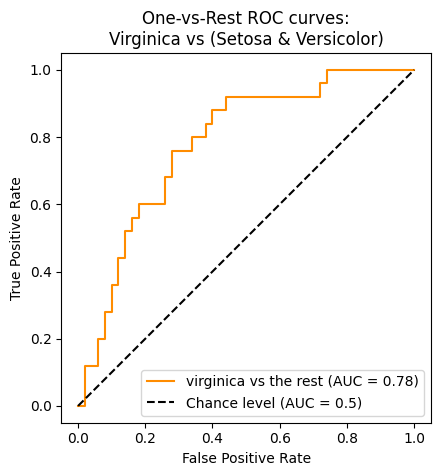

In [7]:
import matplotlib.pyplot as plt

from sklearn.metrics import RocCurveDisplay

RocCurveDisplay.from_predictions(
    y_onehot_test[:, class_id],
    y_score[:, class_id],
    name=f"{class_of_interest} vs the rest",
    color="darkorange",
    plot_chance_level=True,
)
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("One-vs-Rest ROC curves:\nVirginica vs (Setosa & Versicolor)")
plt.legend()
plt.show()

## Courbe ROC utilisant la moyenne micro OvR

La moyenne micro agrège les contributions de toutes les classes (en utilisant `np.ravel`) pour calculer les métriques moyennes de la manière suivante :

$TPR=\frac{\sum_{c}TP_c}{\sum_{c}(TP_c + FN_c)}$ ;  
$FPR=\frac{\sum_{c}FP_c}{\sum_{c}(FP_c + TN_c)}$.

Nous pouvons brièvement illustrer l'effet de `np.ravel` :

In [8]:
print(f"y_score:\n{y_score[0:2,:]}")
print()
print(f"y_score.ravel():\n{y_score[0:2,:].ravel()}")

y_score:
[[0.38272852 0.0510982  0.56617328]
 [0.06993073 0.28143467 0.6486346 ]]

y_score.ravel():
[0.38272852 0.0510982  0.56617328 0.06993073 0.28143467 0.6486346 ]


Dans un cadre de classification multiclasse avec des classes fortement déséquilibrées, la micro-moyenne est préférable à la macro-moyenne. Dans de tels cas, on peut également utiliser une macro-moyenne pondérée, qui n'est pas illustrée ici.

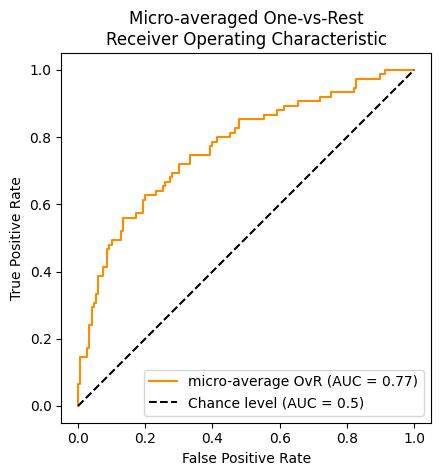

In [12]:
RocCurveDisplay.from_predictions(
    y_onehot_test.ravel(),
    y_score.ravel(),
    name="micro-average OvR",
    color="darkorange",
    plot_chance_level=True,
)
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Micro-averaged One-vs-Rest\nReceiver Operating Characteristic")
plt.legend()
plt.show()

Dans le cas où l'intérêt principal n'est pas le graphique mais le score ROC-AUC lui-même, nous pouvons reproduire la valeur affichée dans le graphique en utilisant [**`roc_auc_score`**](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html).

In [13]:
from sklearn.metrics import roc_auc_score

micro_roc_auc_ovr = roc_auc_score(
    y_test,
    y_score,
    multi_class="ovr",
    average="micro",
)

print(f"Micro-averaged One-vs-Rest ROC AUC score:\n{micro_roc_auc_ovr:.2f}")

Micro-averaged One-vs-Rest ROC AUC score:
0.77


Cela équivaut à calculer la courbe ROC avec [**`roc_curve`**](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve), puis l'aire sous la courbe avec [**`auc`**](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.auc.html) pour les classes vraies et prédites aplaties.

In [14]:
from sklearn.metrics import auc, roc_curve

# store the fpr, tpr, and roc_auc for all averaging strategies
fpr, tpr, roc_auc = {}, {}, {}
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_onehot_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

print(f"Micro-averaged One-vs-Rest ROC AUC score:\n{roc_auc['micro']:.2f}")

Micro-averaged One-vs-Rest ROC AUC score:
0.77


**Note** : Par défaut, le calcul de la courbe ROC ajoute un seul point au taux de faux positifs maximal en utilisant une interpolation linéaire et la correction McClish [[Analyzing a portion of the ROC curve Med Decis Making. 1989 Jul-Sep; 9(3):190-5.](https://journals.sagepub.com/doi/10.1177/0272989X8900900307)].

## Courbe ROC utilisant la macro-moyenne OvR

Pour obtenir la macro-moyenne, il est nécessaire de calculer la métrique indépendamment pour chaque classe, puis de prendre la moyenne. Cela traite toutes les classes de manière équivalente a priori. Nous agrégeons d'abord les taux de vrais/faux positifs par classe :

In [15]:
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_onehot_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr_grid = np.linspace(0.0, 1.0, 1000)

# Interpolate all ROC curves at these points
mean_tpr = np.zeros_like(fpr_grid)

for i in range(n_classes):
    mean_tpr += np.interp(fpr_grid, fpr[i], tpr[i])  # linear interpolation

# Average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = fpr_grid
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

print(f"Macro-averaged One-vs-Rest ROC AUC score:\n{roc_auc['macro']:.2f}")

Macro-averaged One-vs-Rest ROC AUC score:
0.77


Ce calcul est équivalent à l'appel suivant :

In [16]:
macro_roc_auc_ovr = roc_auc_score(
    y_test,
    y_score,
    multi_class="ovr",
    average="macro",
)

print(f"Macro-averaged One-vs-Rest ROC AUC score:\n{macro_roc_auc_ovr:.2f}")

Macro-averaged One-vs-Rest ROC AUC score:
0.77


## Afficher toutes les courbes ROC OvR ensemble

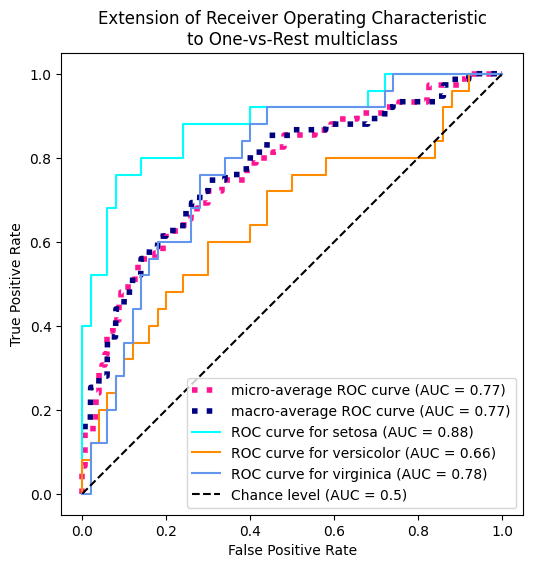

In [17]:
from itertools import cycle

fig, ax = plt.subplots(figsize=(6, 6))

plt.plot(
    fpr["micro"],
    tpr["micro"],
    label=f"micro-average ROC curve (AUC = {roc_auc['micro']:.2f})",
    color="deeppink",
    linestyle=":",
    linewidth=4,
)

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label=f"macro-average ROC curve (AUC = {roc_auc['macro']:.2f})",
    color="navy",
    linestyle=":",
    linewidth=4,
)

colors = cycle(["aqua", "darkorange", "cornflowerblue"])
for class_id, color in zip(range(n_classes), colors):
    RocCurveDisplay.from_predictions(
        y_onehot_test[:, class_id],
        y_score[:, class_id],
        name=f"ROC curve for {target_names[class_id]}",
        color=color,
        ax=ax,
        plot_chance_level=(class_id == 2),
    )

plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Extension of Receiver Operating Characteristic\nto One-vs-Rest multiclass")
plt.legend()
plt.show()

# ROC multiclasse Une-contre-Une (OvO)

La stratégie multiclasse Une-contre-Une (OvO) consiste à entraîner un classifieur pour chaque paire de classes. Étant donné qu'il est nécessaire d'entraîner $\frac{1}{2} n_{\text{classes}} \cdot (n_{\text{classes}} - 1)$ classifieurs, cette méthode est généralement plus lente que la stratégie Une-contre-Toutes (OvR) en raison de sa complexité $\mathcal{O}(n_{\text{classes}}^2)$.

Dans cette section, nous démontrons l'AUC macro-moyenne en utilisant la méthode OvO pour les 3 combinaisons possibles dans le [**Jeu de données des plantes Iris** (7.1.1)](https://scikit-learn.org/stable/datasets/toy_dataset.html#iris-dataset) : "setosa" vs "versicolor", "versicolor" vs "virginica" et "virginica" vs "setosa". Notez que la micro-moyenne n'est pas définie pour la stratégie OvO.

## Courbe ROC utilisant la macro-moyenne OvO

Dans la méthode OvO, la première étape consiste à identifier toutes les combinaisons uniques de paires. Le calcul des scores est effectué en considérant l'un des éléments d'une paire donnée comme la classe positive et l'autre élément comme la classe négative, puis en recalculant le score en inversant les rôles et en prenant la moyenne des deux scores.

In [18]:
from itertools import combinations

pair_list = list(combinations(np.unique(y), 2))
print(pair_list)

[('setosa', 'versicolor'), ('setosa', 'virginica'), ('versicolor', 'virginica')]


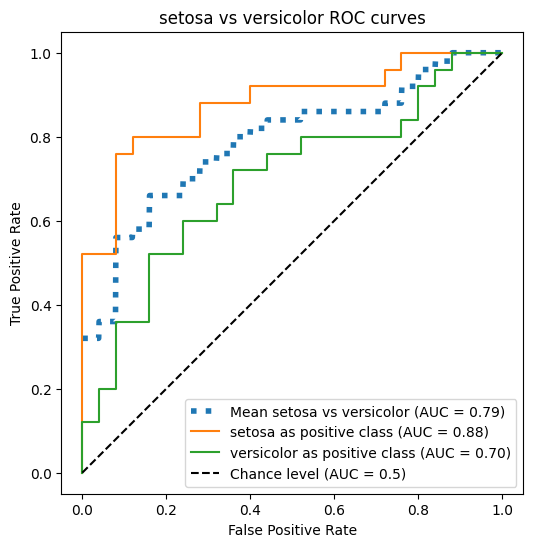

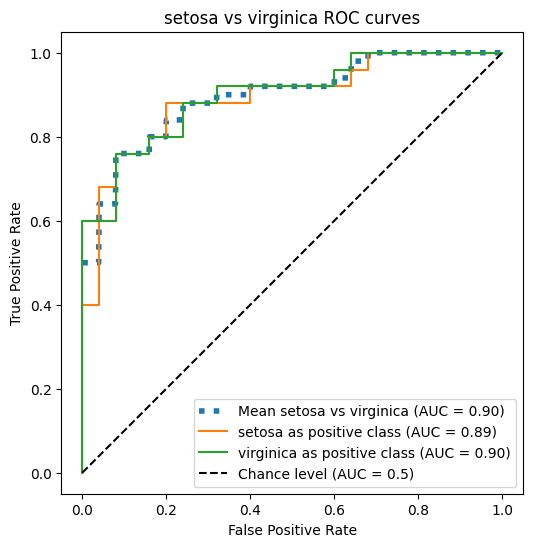

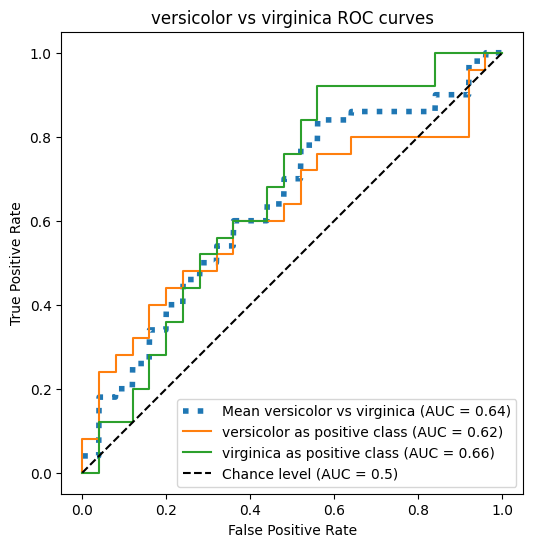

Macro-averaged One-vs-One ROC AUC score:
0.77


In [19]:
pair_scores = []
mean_tpr = {}

for ix, (label_a, label_b) in enumerate(pair_list):
    a_mask = y_test == label_a
    b_mask = y_test == label_b
    ab_mask = np.logical_or(a_mask, b_mask)

    a_true = a_mask[ab_mask]
    b_true = b_mask[ab_mask]

    idx_a = np.flatnonzero(label_binarizer.classes_ == label_a)[0]
    idx_b = np.flatnonzero(label_binarizer.classes_ == label_b)[0]

    fpr_a, tpr_a, _ = roc_curve(a_true, y_score[ab_mask, idx_a])
    fpr_b, tpr_b, _ = roc_curve(b_true, y_score[ab_mask, idx_b])

    mean_tpr[ix] = np.zeros_like(fpr_grid)
    mean_tpr[ix] += np.interp(fpr_grid, fpr_a, tpr_a)
    mean_tpr[ix] += np.interp(fpr_grid, fpr_b, tpr_b)
    mean_tpr[ix] /= 2
    mean_score = auc(fpr_grid, mean_tpr[ix])
    pair_scores.append(mean_score)

    fig, ax = plt.subplots(figsize=(6, 6))
    plt.plot(
        fpr_grid,
        mean_tpr[ix],
        label=f"Mean {label_a} vs {label_b} (AUC = {mean_score :.2f})",
        linestyle=":",
        linewidth=4,
    )
    RocCurveDisplay.from_predictions(
        a_true,
        y_score[ab_mask, idx_a],
        ax=ax,
        name=f"{label_a} as positive class",
    )
    RocCurveDisplay.from_predictions(
        b_true,
        y_score[ab_mask, idx_b],
        ax=ax,
        name=f"{label_b} as positive class",
        plot_chance_level=True,
    )
    plt.axis("square")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"{target_names[idx_a]} vs {label_b} ROC curves")
    plt.legend()
    plt.show()

print(f"Macro-averaged One-vs-One ROC AUC score:\n{np.average(pair_scores):.2f}")

On peut également affirmer que la macro-moyenne que nous avons calculée "manuellement" est équivalente à l'option `average="macro"` implémentée dans la fonction [**`roc_auc_score`**](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html).

In [21]:
macro_roc_auc_ovo = roc_auc_score(
    y_test,
    y_score,
    multi_class="ovo",
    average="macro",
)

print(f"Macro-averaged One-vs-One ROC AUC score:\n{macro_roc_auc_ovo:.2f}")

Macro-averaged One-vs-One ROC AUC score:
0.77


## Afficher toutes les courbes ROC OvO ensemble

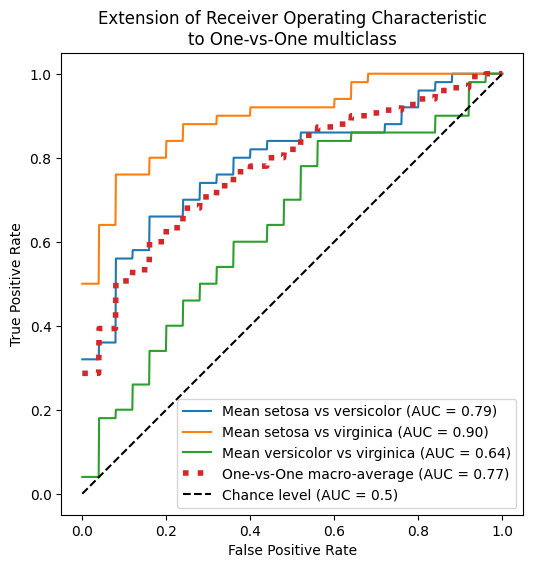

In [22]:
ovo_tpr = np.zeros_like(fpr_grid)

fig, ax = plt.subplots(figsize=(6, 6))
for ix, (label_a, label_b) in enumerate(pair_list):
    ovo_tpr += mean_tpr[ix]
    plt.plot(
        fpr_grid,
        mean_tpr[ix],
        label=f"Mean {label_a} vs {label_b} (AUC = {pair_scores[ix]:.2f})",
    )

ovo_tpr /= sum(1 for _ in enumerate(pair_list))

plt.plot(
    fpr_grid,
    ovo_tpr,
    label=f"One-vs-One macro-average (AUC = {macro_roc_auc_ovo:.2f})",
    linestyle=":",
    linewidth=4,
)
plt.plot([0, 1], [0, 1], "k--", label="Chance level (AUC = 0.5)")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Extension of Receiver Operating Characteristic\nto One-vs-One multiclass")
plt.legend()
plt.show()

Nous confirmons que les classes "versicolor" et "virginica" ne sont pas bien identifiées par un classifieur linéaire. Notez que le score ROC-AUC "virginica" vs "reste" (0,77) se situe entre les scores ROC-AUC OvO pour "versicolor" vs "virginica" (0,64) et "setosa" vs "virginica" (0,90). En effet, la stratégie OvO fournit des informations supplémentaires sur la confusion entre une paire de classes, au détriment du coût de calcul lorsque le nombre de classes est élevé.

La stratégie OvO est recommandée si l'utilisateur est principalement intéressé par l'identification correcte d'une classe particulière ou d'un sous-ensemble de classes, tandis que l'évaluation des performances globales d'un classifieur peut toujours être résumée via une stratégie d'agrégation donnée.

La macro-moyenne OvR est dominée par la classe la plus fréquente, car les compteurs sont regroupés. L'alternative macro-moyenne reflète mieux les statistiques des classes moins fréquentes et est donc plus appropriée lorsque les performances sur toutes les classes sont considérées comme également importantes.